In [11]:
%pip install tensorboard --quiet
%pip install seaborn --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
sys.path.append('/workspace/cropClassification')
sys.path.append('/workspace/cropClassification/model')
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import pandas as pd
from torch.utils.data import DataLoader

from unet import originalUNet, encodeDropUNet
from compiler import ModelCompiler
from dataloader import RoadsideCropImageDataset
from loss import BalancedCrossEntropyLoss

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU with CUDA
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple M1/M2 GPU with MPS (Metal Performance Shaders)
    print("Using MPS")
else:
    device = torch.device("cpu")  # Fall back to CPU
    print("Using CPU")

Using CUDA


### Configuration

In [4]:
config = {
    "model": {
        "type": "UNetWithUncertainty", 
        "params": {
            "in_channels": 10,  # Since we are using 9-channel input images
            "out_channels": 3   # Number of output classes for segmentation
        }
    },
    "training": {
        "epochs": 100,
        "batch_size": 64,
        "learning_rate": 0.01,
        "optimizer": {
            "type": "Adam",
            "params": {
                "lr": 0.01
            }
        },
        "scheduler": {
            "type": "StepLR",
            "params": {
                "step_size": 10,
                "gamma": 0.8
            }
        },
        "criterion": BalancedCrossEntropyLoss,
        "classwise_weights": [0.40847337, 0.24774314, 0.34378349],
        "resume" : False,
        "resume_epoch" : None,
    },
    "validation": {
        "epochs": 50,
        "batch_size": 16
    },
    "dataset": {
        "train_csv": "/workspace/data/masked_data_csiss/training/train_chipping_csv_w_anc.csv",  # Path to the training DataFrame (includes npy file paths)
        "val_csv": "/workspace/data/masked_data_csiss/validation/validation_chipping_csv_w_anc.csv", # Path to the validation DataFrame (includes npy file paths)
        "train_root_path": "/workspace/data/masked_data_csiss/training",
        "val_root_path": "/workspace/data/masked_data_csiss/validation",
        "image_column": "img_chip_path",             # Column containing the image paths (npy files)
        "mask_column": "lbl_chip_path",              # Column containing the mask paths
        "train_mean": [93.35909, 112.25017, 77.58077, 113.76227, 209.35867, 
                       33.197624, 47.543148, 115.10287, 116.46991, 0.4089894],  # Mean values for training set normalization
        "train_std": [52.684902, 47.859867, 48.691204, 48.87318, 79.684715, 
                      55.719467, 22.692726, 52.473957, 49.270615, 0.18757315],   # Std values for training set normalization
        "val_mean": [86.912254, 111.033424, 76.70707, 111.44443, 222.71599, 
                     32.308598, 51.314415, 117.117516, 114.03275, 0.4002856],    # Mean values for validation set normalization
        "val_std": [53.11299, 48.662193, 49.91134, 49.917503, 60.49611, 
                    55.28856, 21.68052, 54.39602, 50.282692, 0.1894794],     # Std values for validation set normalization
        "classwise_norm": {
            "Other": {
                "mean": [110.14499, 138.28326, 117.67161, 138.71075, 233.10298, 95.24617, 
                         61.51174, 95.255585, 143.12497, 0.5121758],
                "std": [49.80741, 58.08042, 73.33471, 56.73531, 46.3197, 107.53641, 
                        27.30666, 48.58509, 61.8592, 0.22473]
            },
            "Maize": {
                "mean": [90.51625, 108.20322, 72.41352, 109.907, 203.1153, 24.78379, 
                         45.99272, 118.35542, 112.66669, 0.39319476],
                "std": [53.35697, 45.1693, 41.97862, 46.84034, 85.41561, 37.93971, 
                        21.92598, 52.69628, 46.29754, 0.1780796]
            },
            "Soybean": {
                "mean": [83.55291, 101.03232, 66.89771, 102.10976, 220.03397, 28.55189, 
                         47.94096, 116.89587, 103.48843, 0.36566228],
                "std": [49.91921, 47.52045, 41.91468, 48.74042, 67.89334, 47.91879, 
                        20.7751, 53.59672, 48.15541, 0.18223667]
            },
        }
    },
    "evaluation": {
        "filename": "csiss_street_view_crop_classification.csv",  # Evaluation metrics to be used
        "class_mapping": {
            0: "Background",
            1: "Maize",
            2: "Soybean"
        }
    }
}


### Loading Datasets

In [5]:
train_df = pd.read_csv(config['dataset']['train_csv'])
val_df = pd.read_csv(config['dataset']['val_csv'])

In [6]:
train_dataset = RoadsideCropImageDataset(
    dataframe=train_df,
    root_dir=config['dataset']['train_root_path'],  # Root directory where images are stored
    usage='train',  # Indicates training dataset
    mean=config['dataset']['train_mean'],
    std=config['dataset']['train_std']
)

val_dataset = RoadsideCropImageDataset(
    dataframe=val_df,
    root_dir=config['dataset']['val_root_path'],  # Root directory where images are stored
    usage='val',  # Indicates validation dataset
    mean=config['dataset']['val_mean'],
    std=config['dataset']['val_std']
)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['training']['batch_size'], shuffle=False)

### Construct Model and Training

##### Original UNet

In [8]:
model = originalUNet(n_channels=config['model']['params']['in_channels'],
                     n_classes=config['model']['params']['out_channels'])
model_comp = ModelCompiler(model=model,
                           params_init=None)

---------- GPU (CUDA) available ----------
Total number of trainable parameters: 13.4M


In [9]:
model_comp.fit(
    trainDataset=train_loader,
    valDataset=val_loader,
    epochs=config['training']['epochs'],
    optimizer_name=config['training']['optimizer']['type'],
    lr_init=config['training']['learning_rate'],
    lr_policy='steplr',  # Use 'steplr' as specified in config
    criterion=config['training']['criterion'],
    # class_weights=config['training']['classwise_weights'],
    log=True,  # Enable logging for TensorBoard
    return_loss=False,
    use_ancillary=False,
    **config['training']['scheduler']['params'])

Using Balanced Cross Entropy Loss.
-------------------------- Start training --------------------------
----------------------- [1/100] -----------------------
Epoch Training Loss: 0.8749
Current Learning Rate: 0.010000
Validation Loss: 0.8729
Epoch 1 completed in 2840.42 seconds
----------------------- [2/100] -----------------------
Epoch Training Loss: 0.8276
Current Learning Rate: 0.010000
Validation Loss: 1.0219
Epoch 2 completed in 2649.31 seconds
----------------------- [3/100] -----------------------
Epoch Training Loss: 0.8158
Current Learning Rate: 0.010000
Validation Loss: 1.0003
Epoch 3 completed in 2707.06 seconds
----------------------- [4/100] -----------------------
Epoch Training Loss: 0.7960
Current Learning Rate: 0.010000
Validation Loss: 0.8774
Epoch 4 completed in 2818.17 seconds
----------------------- [5/100] -----------------------
Epoch Training Loss: 0.7805
Current Learning Rate: 0.010000
Validation Loss: 0.7523
Epoch 5 completed in 2814.41 seconds
-----------

-------------------------- Start Evaluation --------------------------
Saving metrics to: outputs/originalUNet/csiss_street_view_crop_classification.csv
Saving confusion matrix to: outputs/originalUNet/confusion_matrix.png


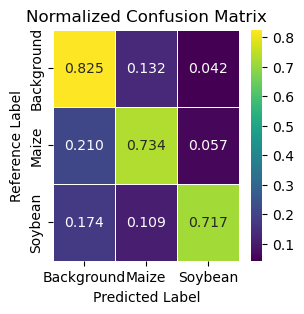

-------------------------- Evaluation Complete --------------------------
Aggregated Metrics:
Overall Accuracy: 0.7466
Mean Accuracy: 0.7588
Mean IoU: 0.5851
Mean Precision: 0.7420
Mean Recall: 0.7588
Mean F1 Score: 0.7340

Class-Wise Metrics:
Background: Accuracy: 0.8255, Precision: 0.5080, Recall: 0.8255, IoU: 0.4588, F1 Score: 0.6290
Maize: Accuracy: 0.7336, Precision: 0.8582, Recall: 0.7336, IoU: 0.6543, F1 Score: 0.7910
Soybean: Accuracy: 0.7172, Precision: 0.8599, Recall: 0.7172, IoU: 0.6421, F1 Score: 0.7821


In [11]:
model_comp.evaluate(dataloader=val_loader,
                    num_classes=config['model']['params']['out_channels'],
                    class_mapping=config['evaluation']['class_mapping'],
                    out_name=config['evaluation']['filename'],  
                    log_uncertainty=False)

##### Encoder Dropout UNet

In [18]:
model = encodeDropUNet(n_channels=config['model']['params']['in_channels'],
                     n_classes=config['model']['params']['out_channels'],
                     drop_rate=0.3)
model_comp = ModelCompiler(model=model,
                           params_init=None)

---------- GPU (CUDA) available ----------
Total number of trainable parameters: 13.4M
---------- encodeDropUNet model compiled successfully ----------


In [19]:
model_comp.fit(
    trainDataset=train_loader,
    valDataset=val_loader,
    epochs=config['training']['epochs'],
    optimizer_name=config['training']['optimizer']['type'],
    lr_init=config['training']['learning_rate'],
    lr_policy='steplr',  # Use 'steplr' as specified in config
    criterion=config['training']['criterion'],
    log=True,  # Enable logging for TensorBoard
    return_loss=False,
    **config['training']['scheduler']['params'])

-------------------------- Start training --------------------------
----------------------- [1/50] -----------------------
Epoch Training Loss: 0.9558
Current Learning Rate: 0.100000
Validation Loss: 0.8886
Epoch 1 completed in 1869.37 seconds
----------------------- [2/50] -----------------------
Epoch Training Loss: 0.8669
Current Learning Rate: 0.100000
Validation Loss: 0.8362
Epoch 2 completed in 1858.04 seconds
----------------------- [3/50] -----------------------
Epoch Training Loss: 0.8664
Current Learning Rate: 0.100000
Validation Loss: 0.8324
Epoch 3 completed in 1768.18 seconds
----------------------- [4/50] -----------------------
Epoch Training Loss: 0.8747
Current Learning Rate: 0.100000
Validation Loss: 0.8373
Epoch 4 completed in 1706.91 seconds
----------------------- [5/50] -----------------------
Epoch Training Loss: 0.8662
Current Learning Rate: 0.100000
Validation Loss: 0.8012
Epoch 5 completed in 1708.13 seconds
----------------------- [6/50] --------------------

---------------- Start evaluation ----------------


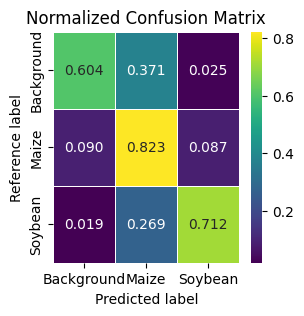

---------------- Evaluation finished in 346s ----------------


In [20]:
model_comp.accuracy_evaluation(eval_dataset=val_loader,
                               filename=config['evaluation']['filename'], 
                               num_classes=config['model']['params']['out_channels'], 
                               class_mapping=config['evaluation']['class_mapping'])